# Policy based RL
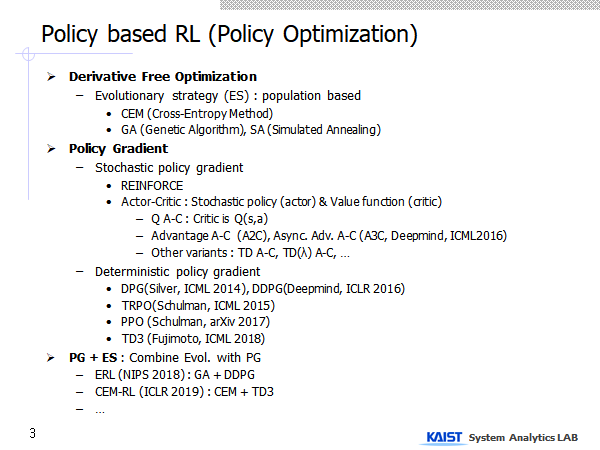

# CEM (Cross Entropy Method)

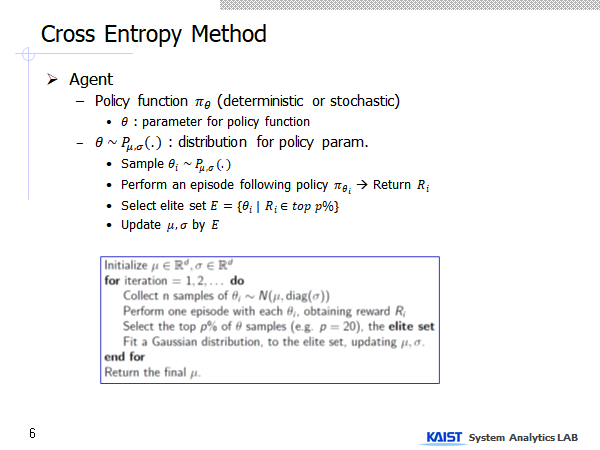

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Reward definition function

- Default reward : +1 for each step
- We separate a reward function for reward modification later

In [9]:
def reward(obs, r):
#     return np.float32(r)
    ang = np.abs(obs[2])
    return np.float32(r + 10*ang)

## Simple agent with linear policy

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def segTuple(self, s, a, r, sp, done):
        seg = (s, a, r, sp, done)
        return seg

    def push(self, s, a, r, sp, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = self.segTuple(s,a,r,sp,done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def clear(self):
        self.position = 0
        self.memory = []

    def getLast(self):
        p = self.position - 1
        if p < 0:  p = self.capacity - 1
        return self.memory[p]

In [10]:
class AgentBase:
    def __init__(self, env):
        self.env = env
        self.eps = 0.5
        self.dimState = env.observation_space.shape[0]
        self.dimAction = env.action_space.n
        self.gamma = 0.99
        self.rb = ReplayMemory(50000)

    def getStateRep(self, obs):
        return obs

    def getQ(self, s):
        return self.Q[s]

    def piGreedy(self, state):
        q = self.getQ(state)
        a = q.argmax()
        return a

    def getAction(self, state):  # eps-greedy policy
        # eps-greedy
        if np.random.random() < self.eps:
            a = np.random.choice(self.dimAction)
            self.eps *= 0.99
            # print (f"exploration move, eps={self.eps}")
        else:
            a = self.piGreedy(state)
        return a

    @staticmethod
    def getSigmoid(z):
        exp_z = np.exp(z)
        return exp_z / (1+exp_z)

    @staticmethod
    def getSoftmax(z, tau=1):
        exp_z = np.exp((z - np.max(z)) / tau)
        return exp_z / exp_z.sum()

    def piSoftmax(self, state):
        q = self.getQ(state)
        p = self.getSoftmax(q).reshape(-1)
        a = np.random.choice(self.dimAction, p=p)
        return a

    def runEpisode1(self, saveRB=True, maxStep=200, render=False):
        obs = self.env.reset()
        s = self.getStateRep(obs)
        done = False
        ret = 0
        nStep = 0
        while not done:
            if render:
                self.env.render()
            a = self.getAction(s)
            # a = self.piSoftmax(s)
            obs, r, done, info = self.env.step(a)
            r = reward(obs, r)
            ret += r
            sp = self.getStateRep(obs)
            if saveRB:
                self.rb.push(s, a, r, sp, done)
            s = sp
            nStep += 1
            if nStep >= maxStep:  # 500 for v1
                break
        self.nStep = nStep
        if not done and self.gamma < 1:
            ret += r / (1-self.gamma)
        return ret
    
    
    def runTest(self, nEpisode=1, maxStep=1000):
        eps = self.eps
        self.eps = 0
        i = 0
        while i < nEpisode:
            i += 1
            ret = self.runEpisode1(saveRB=False, maxStep=maxStep, render=True)
            print(f"Test episode {i}, return = {ret} in {self.nStep} steps")
        self.eps = eps

In [11]:
class AgentLinPolicy(AgentBase):
    def getW(self, mu, sigma):
        sz = (1, self.dimState)
        z = np.random.normal(size=sz)
        self.w = mu + sigma * z

    def getAction(self, state):  # policy function
        z = np.dot(self.w, state)
        if z < 0:
#         if self.getSigmoid(z) < np.random.random():
            a = 0
        else:
            a = 1
        return a

    def runEpisodeN(self, saveRB=True, maxStep=200, nEpisodes=1):
        retSum = 0.0
        for i in range(nEpisodes):
            retSum += self.runEpisode1(saveRB, maxStep)
        self.ret = retSum / nEpisodes

    def __lt__(self, other):
        return self.ret < other.ret


## CEM class : cross entropy method

In [12]:
class CEM:
    def __init__(self, sigma=1.0, nPop=100, nGen=10):
        self.env = gym.make('CartPole-v0').unwrapped
        self.dimState = self.env.observation_space.shape[0]
        sz = (1, self.dimState)

        self.mu = np.zeros(sz)
        self.sigma = np.full(sz, sigma)
        self.nPop = nPop
        self.elitePortion = 0.2
        self.nGen = nGen

    def initPop(self):
        self.agentSet = []
        for i in range(self.nPop):
            env = gym.make('CartPole-v0').unwrapped
            agent = AgentLinPolicy(env)
            agent.getW(self.mu, self.sigma)
            self.agentSet.append(agent)

    def sampleAgents(self):
        for a in self.agentSet:
            a.getW(self.mu, self.sigma)

    def runAgents(self, maxStep=200, nEpisodes=1):
        for a in self.agentSet:
            a.runEpisodeN(saveRB=False, maxStep=maxStep, nEpisodes=nEpisodes)

    def computeWeight(self, nElite):  # return proportional weight
        p = np.full(nElite, 1/nElite)
        return p

    def updatePopParam(self):
        self.agentSet.sort(reverse=True)
        nElite = math.floor(len(self.agentSet) * self.elitePortion)
        # print (f"{self.elitePortion*100:.0f}% return = {self.pop[nElite].ret}")
        p = self.computeWeight(nElite)

        w = self.agentSet[0].w
        muNew = p[0] * w
        sigmaNew = p[0] * (w - self.mu)**2
        sumRet = self.agentSet[0].ret
        for i in range(1, nElite):
            w = self.agentSet[i].w
            muNew += p[i] * w
            sigmaNew += p[i] * (w - self.mu) ** 2
            sumRet += self.agentSet[i].ret

        self.mu = muNew
        self.sigma = np.sqrt(sigmaNew)
        return sumRet / nElite, self.agentSet[0].ret, self.agentSet[nElite].ret

    def bestw(self):
        return self.agentSet[0].w

    def runMany(self, maxStep=500):
        retHist = []
        self.initPop()
        for i in range(self.nGen):
            self.sampleAgents()
            self.runAgents(maxStep=maxStep)
            rMean, rMax, rMin = self.updatePopParam()
            print (f"iteration {i+1}, 20% max, mean, min = ({rMax:.2f}, {rMean:.2f}, {rMin:.2f})")
            print (f"mu    = {self.mu}")
            print (f"sigma = {self.sigma}")
            retHist.append(rMean)
        plt.plot(retHist)
        plt.show()

iteration 1, 20% max, mean, min = (635.83, 230.64, 101.16)
mu    = [[-0.30828317 -0.26382664  0.06976324  0.73799375]]
sigma = [[1.13721756 0.6013236  0.80025676 0.85839136]]
iteration 2, 20% max, mean, min = (2163.91, 805.78, 208.24)
mu    = [[-0.34535606  0.32963535  0.50745692  1.33012126]]
sigma = [[0.56417734 0.66884542 0.65887346 0.82370907]]
iteration 3, 20% max, mean, min = (2413.07, 1297.57, 515.95)
mu    = [[-0.13121949  0.81748388  0.72043169  1.56510199]]
sigma = [[0.31707762 0.56478266 0.56728725 0.5375211 ]]
iteration 4, 20% max, mean, min = (3621.75, 2314.59, 1425.49)
mu    = [[0.00215394 0.78411244 1.06670723 1.68307517]]
sigma = [[0.18427712 0.42147355 0.5302748  0.59903875]]
iteration 5, 20% max, mean, min = (3087.73, 2563.23, 2190.40)
mu    = [[0.06572383 0.83225909 1.17484697 2.00092052]]
sigma = [[0.09924763 0.35929426 0.33670299 0.61619907]]
iteration 6, 20% max, mean, min = (3648.58, 2869.94, 2413.88)
mu    = [[0.09148778 0.98731824 1.23851822 2.43211074]]
sigma 

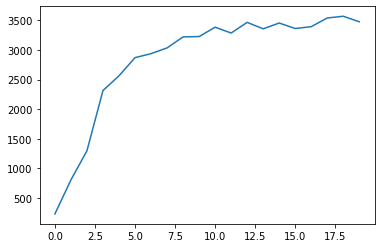

mu =  [[0.08999814 0.92452548 1.40462975 3.32062197]]
best w =  [[0.09715918 0.85614115 1.42108213 3.29885006]]


In [14]:
pop = CEM(sigma=1, nPop=50, nGen=20)
pop.runMany(maxStep=2000)
np.save(f"saved/CEM-mu", pop.mu)
print ("mu = ", pop.mu)
np.save(f"saved/CEM-best", pop.bestw())
print ("best w = ", pop.bestw())

In [ ]:
env = gym.make('CartPole-v0').unwrapped
env = gym.wrappers.Monitor(pop.env, 'Cartpole-v0.CEM', force=True)
w = np.load("saved/CEM-mu.npy")
# w = np.load("saved/CEM-best.npy")
print (f"w = {w}")
agent = AgentLinPolicy(env)
# agent.w = self.mu
agent.w = w
agent.runTest()
env.close()

## Modify reward : 1 + 10*|pole angle| at each step

In [15]:
def reward(obs, r):
    return np.float32(r + 10*np.abs(obs[2]))

iteration 1, 20% max, mean, min = (880.76, 300.19, 111.87)
mu    = [[-0.11814915 -0.18121254  0.25454774  1.17380292]]
sigma = [[0.88793431 1.06619965 0.82164491 1.3803608 ]]
iteration 2, 20% max, mean, min = (2280.73, 829.73, 392.64)
mu    = [[-0.08863539  0.40948105  0.95515498  2.130035  ]]
sigma = [[0.42833538 1.12785909 1.10625043 1.31402437]]
iteration 3, 20% max, mean, min = (3053.97, 2090.45, 1066.42)
mu    = [[0.02921825 0.72465701 1.9164204  2.03190698]]
sigma = [[0.20040266 1.05108612 1.24398518 0.9756677 ]]
iteration 4, 20% max, mean, min = (2477.60, 2297.01, 2185.85)
mu    = [[0.08294191 1.25313266 1.75162612 2.52054242]]
sigma = [[0.15926215 0.92783186 0.50746766 0.75118199]]
iteration 5, 20% max, mean, min = (3780.20, 2663.30, 2343.34)
mu    = [[0.08425649 1.26390408 1.58860664 2.96290755]]
sigma = [[0.09991582 0.65114451 0.34340269 0.59092042]]
iteration 6, 20% max, mean, min = (3581.46, 3062.51, 2659.51)
mu    = [[0.08838608 1.20542196 1.46327707 3.38312742]]
sigma = [

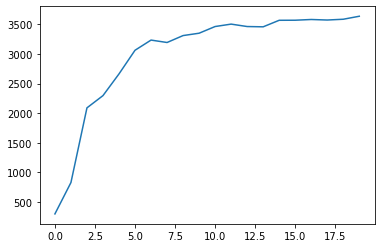

mu =  [[0.02852869 1.44104499 1.46946499 4.06608815]]
best w =  [[0.04187407 1.66633927 1.48482396 4.08942878]]


In [16]:
pop = CEM(sigma=1, nPop=100, nGen=20)
pop.runMany(maxStep=2000)
np.save(f"CEM-mu", pop.mu)
print ("mu = ", pop.mu)
np.save(f"CEM-best", pop.bestw())
print ("best w = ", pop.bestw())

In [17]:
env = gym.make('CartPole-v0').unwrapped
# env = gym.wrappers.Monitor(pop.env, 'Cartpole-v0.CEM', force=True)
w = np.load("CEM-mu.npy")
# w = np.load("CEM-best.npy")
print (f"w = {w}")
agent = AgentLinPolicy(env)
# agent.w = self.mu
agent.w = w
agent.runTest(maxStep=2000)
env.close()

w = [[0.02852869 1.44104499 1.46946499 4.06608815]]
Test episode 1, return = 3230.3607442379 in 1889 steps


In [14]:
env.close()

In [ ]:
pop = CEM(sigma=1, nPop=100, nGen=20)
pop.runMany(maxStep=2000)
np.save(f"CEM-mu", pop.mu)
print ("mu = ", pop.mu)
np.save(f"CEM-best", pop.bestw())
print ("best w = ", pop.bestw())

In [ ]:
env = gym.make('CartPole-v0').unwrapped
# env = gym.wrappers.Monitor(pop.env, 'Cartpole-v0.CEM', force=True)
# w = np.load("CEM-mu.npy")
w = np.load("CEM-best.npy")
print (f"w = {w}")
agent = AgentLinPolicy(env)
# agent.w = self.mu
agent.w = w
agent.runTest(maxStep=2000)
env.close()

In [18]:
class CEM2(CEM):  # Weighted averga
    def computeWeight(self, nElite):  # return proportional weight
        W = np.zeros(nElite)
        sum = 0
        for i in range(nElite):
            v = self.agentSet[i].ret  # return proportional weight
#             v = math.log((1+nElite)/(1+i)) # rank based weight
            W[i] = v
            sum += W[i]
        W /= sum
        return W

iteration 1, 20% max, mean, min = (2210.47, 494.62, 146.73)
mu    = [[ 0.10068758 -0.33970127  1.02460009  0.85199265]]
sigma = [[0.74238041 0.71387409 1.45831392 1.23048615]]
iteration 2, 20% max, mean, min = (2691.51, 2153.18, 948.32)
mu    = [[ 0.41293105 -0.04903779  2.25072725  1.01332284]]
sigma = [[0.44184229 0.55721131 1.43908982 0.54203414]]
iteration 3, 20% max, mean, min = (2206.58, 2174.66, 2166.33)
mu    = [[0.34981033 0.23232198 2.62462402 1.45233144]]
sigma = [[0.29623066 0.64214583 1.00517678 0.73206846]]
iteration 4, 20% max, mean, min = (2831.88, 2276.72, 2173.58)
mu    = [[0.42879257 0.5757     2.56596828 1.86246293]]
sigma = [[0.28482562 0.73572438 0.80328681 0.59262308]]
iteration 5, 20% max, mean, min = (2848.36, 2285.70, 2178.43)
mu    = [[0.50207344 0.56163624 2.41070288 2.1000313 ]]
sigma = [[0.21750093 0.5471642  0.65332404 0.55982714]]
iteration 6, 20% max, mean, min = (3255.24, 2424.98, 2215.78)
mu    = [[0.42736016 0.73716909 2.28068928 2.11649204]]
sigma =

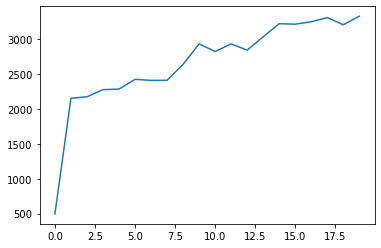

mu =  [[0.32824797 1.09036241 1.71280768 2.66813461]]
best w =  [[0.33331488 1.01457102 1.74909412 2.64017245]]
w = [[0.33331488 1.01457102 1.74909412 2.64017245]]
Test episode 1, return = 2623.327837705612 in 2000 steps


In [19]:
pop = CEM2(sigma=1, nPop=100, nGen=20)
pop.runMany(maxStep=2000)
np.save(f"CEM-mu", pop.mu)
print ("mu = ", pop.mu)
np.save(f"CEM-best", pop.bestw())
print ("best w = ", pop.bestw())

env = gym.make('CartPole-v0').unwrapped
w = np.load("CEM-best.npy")
print (f"w = {w}")
agent = AgentLinPolicy(env)
agent.w = w
agent.runTest(maxStep=2000)
env.close()